# 필요 라이브러리

In [1]:
import os
import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
sys.path.append('/project/kcure-08/lib/python3.7/site-packages')

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier, Pool
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import lightgbm as lgb
import random
import sklearn
import shap


from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import randint

In [2]:
print(os.getcwd()) # 현재 경로
# print(os.listdir(os.getcwd())) # 현재 경로 파일

os.chdir('/project/kcure-08/src/1. Data/1. Colon') # 현재 경로 변경(데이터 파일)
print(os.getcwd())
# print(os.listdir(os.getcwd()))

/project/kcure-08/src/2. Model/1. Colon
/project/kcure-08/src/1. Data/1. Colon


# 1. 데이터 불러오기

In [3]:
### 최종 재발과 재발없는 피험자 테이블 불러오기 ###
df_cs_cc_rec = pd.read_csv('./PP_csv/cs_cc_rec_fin.csv') # 암 재발 피험자
df_cs_cc_nrec = pd.read_csv('./PP_csv/cs_cc_nrec_fin.csv') # 암 재발이 없는 피험자 (대장암 진단 이후)

In [ ]:
##### 재발여부 상관없이 데이터 합치기 
df = pd.concat([df_cs_cc_rec, df_cs_cc_nrec], ignore_index = True)
df

# 2. 데이터 전처리하기

### 1. 불필요한 변수 제거 및 파생변수 생성
- [파생변수] : 재발시기(1년), 수술횟수, 요양식별기관(대,중도시), 흡연횟수, 알코올함량, 하루 알코올 섭취량 위험도, 신체활동량

In [6]:
df['TIME_OF_REC'].fillna('0 days', inplace = True) # NaN 값을 0 day 으로 처리 (재발없는 피험자)
df['TIME_OF_REC'] = df['TIME_OF_REC'].str.replace('days', '').astype(float).fillna(0).astype(int) # str(day)를 제거한뒤 int형으로 변환
df['TIME_OF_REC'] = pd.cut(df['TIME_OF_REC'],
                            bins = [-float('inf'), 0, 365, 730, 1095, 1460, 1825, float('inf')],
                            labels = [0, 1, 2, 3, 4, 5, 6],
                            include_lowest=True).astype(int) ## 1년단위로 범주화

In [ ]:
col_drop = ['TIME_OF_NREC_END', 'TIME_OF_REC_START', 'FDX'] # 날짜 데이터 삭제
df = df.drop(columns = col_drop)
df.head(1)

In [ ]:
col_drop = ['TIME_OF_REC'] # Feature 강하게 띄는 변수 제거
df = df.drop(columns = col_drop)
df.head(1)

### 2. Null 데이터 처리 (KNN Imputer) - 결측값 대치방법

In [9]:
### df 순서변경
'''현재 칼럼명 : ['SN_KEY', 'LABEL', 'RES', 'SOPR_Y_CNT', 'HGHT', 'WGHT',
       'BMI', 'WSTC', 'BP_SYS', 'BP_DIA', 'URN_PROT', 'HGB', 'FBS', 'SGOT',
       'SGPT', 'GGT', 'TG', 'HDL', 'LDL', 'TOT_CHOL', 'CRTN', 'GFR',
       'Q_FHX_ETC', 'Q_PHX_YN', 'Q_PHX_DX_STK', 'Q_PHX_DX_HTDZ',
       'Q_PHX_DX_HTN', 'Q_PHX_DX_DM', 'Q_PHX_DX_PTB', 'Q_PHX_DX_DLD',
       'Q_PHX_DX_ETC', 'Q_PHX_TX_STK', 'Q_PHX_TX_HTDZ', 'Q_PHX_TX_HTN',
       'Q_PHX_TX_DM', 'Q_PHX_TX_DLD', 'Q_PHX_TX_ETC', 'Q_SMK_YN',
       'Q_DAILY_DRK', 'Q_DRK_RISK', 'Q_PA_WGT_AVG', 'SEX', 'TCODE',
       'MCODE_GRP', 'GRADE', 'AGE', 'T_SIZE', 'EXT', 'LNPOS', 'METS', 'SSF1',
       'SSF8', 'SSF9', 'AJCC6_T', 'AJCC6_TEVAL', 'AJCC6_N', 'AJCC6_NEVAL',
       'AJCC6_M', 'AJCC6_MEVAL', 'AJCC6_STAGE', 'SS2000', 'WT_LSS',
       'WT_LSS_AMT', 'QC_PFHX_CST_YN', 'QC_PFHX_CST_I', 'QC_PFHX_CBR_YN',
       'QC_PFHX_CBR_I', 'QC_PFHX_CCR_YN', 'QC_PFHX_CCR_I', 'QC_PFHX_CLV_YN',
       'QC_PFHX_CLV_I', 'QC_PFHX_CCX_YN', 'QC_PFHX_CCX_I', 'QC_PFHX_ETC_YN',
       'QC_PFHX_ETC_I', 'QC_PHX_PU_YN', 'QC_PHX_ATGS_YN', 'QC_PHX_INMT_YN',
       'QC_PHX_GPO_YN', 'QC_PHX_ST_ETC', 'QC_PHX_CRA_YN', 'QC_PHX_CD_YN',
       'QC_PHX_HMR_YN', 'QC_PHX_LV_YN', 'QC_PHX_CHB_YN', 'QC_PHX_CHC_YN']'''

df = df[['SN_KEY', 'LABEL','SEX', 'AGE', 'RES', 'SOPR_Y_CNT', 'HGHT', 'WGHT',
       'BMI', 'WSTC', 'BP_SYS', 'BP_DIA', 'URN_PROT', 'HGB', 'FBS', 'SGOT',
       'SGPT', 'GGT', 'TG', 'HDL', 'LDL', 'TOT_CHOL', 'CRTN', 'GFR', 'TCODE',
       'MCODE_GRP', 'GRADE',  'T_SIZE', 'EXT', 'LNPOS', 'METS', 'SSF1',
       'SSF8', 'SSF9', 'AJCC6_T', 'AJCC6_TEVAL', 'AJCC6_N', 'AJCC6_NEVAL',
       'AJCC6_M', 'AJCC6_MEVAL', 'AJCC6_STAGE', 'SS2000', 'WT_LSS', 'Q_SMK_YN',
       'Q_DAILY_DRK', 'Q_DRK_RISK', 'Q_PA_WGT_AVG',
       'Q_FHX_ETC', 'Q_PHX_YN', 'Q_PHX_DX_STK', 'Q_PHX_DX_HTDZ',
       'Q_PHX_DX_HTN', 'Q_PHX_DX_DM', 'Q_PHX_DX_PTB', 'Q_PHX_DX_DLD',
       'Q_PHX_DX_ETC', 'Q_PHX_TX_STK', 'Q_PHX_TX_HTDZ', 'Q_PHX_TX_HTN',
       'Q_PHX_TX_DM', 'Q_PHX_TX_DLD', 'Q_PHX_TX_ETC',
       'WT_LSS_AMT', 'QC_PFHX_CST_YN', 'QC_PFHX_CST_I', 'QC_PFHX_CBR_YN',
       'QC_PFHX_CBR_I', 'QC_PFHX_CCR_YN', 'QC_PFHX_CCR_I', 'QC_PFHX_CLV_YN',
       'QC_PFHX_CLV_I', 'QC_PFHX_CCX_YN', 'QC_PFHX_CCX_I', 'QC_PFHX_ETC_YN',
       'QC_PFHX_ETC_I', 'QC_PHX_PU_YN', 'QC_PHX_ATGS_YN', 'QC_PHX_INMT_YN',
       'QC_PHX_GPO_YN', 'QC_PHX_ST_ETC', 'QC_PHX_CRA_YN', 'QC_PHX_CD_YN',
       'QC_PHX_HMR_YN', 'QC_PHX_LV_YN', 'QC_PHX_CHB_YN', 'QC_PHX_CHC_YN']] ### 칼럼명 변경

df.columns = ['SN_KEY', 'LABEL','SEX', 'AGE', 'CL_CD', 'SOPR_Y_CNT', 'HGHT', 'WGHT',
       'BMI', 'WSTC', 'BP_SYS', 'BP_DIA', 'URN_PROT', 'HGB', 'FBS', 'SGOT',
       'SGPT', 'GGT', 'TG', 'HDL', 'LDL', 'TOT_CHOL', 'CRTN', 'GFR', 'TCODE',
       'MCODE_GRP', 'GRADE',  'T_SIZE', 'EXT', 'LNPOS', 'METS', 'SSF1',
       'SSF8', 'SSF9', 'AJCC6_T', 'AJCC6_TEVAL', 'AJCC6_N', 'AJCC6_NEVAL',
       'AJCC6_M', 'AJCC6_MEVAL', 'AJCC6_STAGE', 'SS2000', 'WT_LSS', 'Q_SMK_YN',
       'Q_DAILY_DRK', 'Q_DRK_RISK', 'Q_PA_WGT_AVG',
       'Q_FHX_ETC', 'Q_PHX_YN', 'Q_PHX_DX_STK', 'Q_PHX_DX_HTDZ',
       'Q_PHX_DX_HTN', 'Q_PHX_DX_DM', 'Q_PHX_DX_PTB', 'Q_PHX_DX_DLD',
       'Q_PHX_DX_ETC', 'Q_PHX_TX_STK', 'Q_PHX_TX_HTDZ', 'Q_PHX_TX_HTN',
       'Q_PHX_TX_DM', 'Q_PHX_TX_DLD', 'Q_PHX_TX_ETC',
       'WT_LSS_AMT', 'QC_PFHX_CST_YN', 'QC_PFHX_CST_I', 'QC_PFHX_CBR_YN',
       'QC_PFHX_CBR_I', 'QC_PFHX_CCR_YN', 'QC_PFHX_CCR_I', 'QC_PFHX_CLV_YN',
       'QC_PFHX_CLV_I', 'QC_PFHX_CCX_YN', 'QC_PFHX_CCX_I', 'QC_PFHX_ETC_YN',
       'QC_PFHX_ETC_I', 'QC_PHX_PU_YN', 'QC_PHX_ATGS_YN', 'QC_PHX_INMT_YN',
       'QC_PHX_GPO_YN', 'QC_PHX_ST_ETC', 'QC_PHX_CRA_YN', 'QC_PHX_CD_YN',
       'QC_PHX_HMR_YN', 'QC_PHX_LV_YN', 'QC_PHX_CHB_YN', 'QC_PHX_CHC_YN'] ###  RES --> CL_CD

### 학습/검증/시험 데이터 분리

In [10]:
from sklearn.model_selection import train_test_split

### Train, Test 분할 8: 2
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='LABEL'), df['LABEL'], 
                                                    test_size=0.2, shuffle=True, stratify=df['LABEL'], random_state = 42)


## Train, valid 분할 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                    test_size=0.25, shuffle=True, stratify=y_train, random_state = 42)

In [11]:
X_train_id = X_train.pop('SN_KEY') ### key값 따로저장
X_test_id = X_test.pop('SN_KEY')
X_val_id = X_val.pop('SN_KEY')

In [12]:
imputer = KNNImputer(n_neighbors=2)
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns = X_train.columns)
X_val_imputed =  pd.DataFrame(imputer.transform(X_val), columns = X_val.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns = X_test.columns)

### 3. 불균형 클래스 처리

<AxesSubplot:>

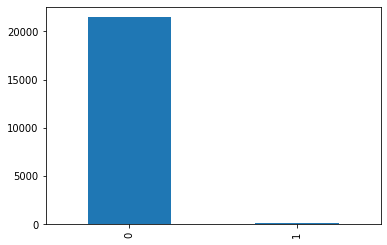

In [13]:
df['LABEL'].value_counts().plot(kind ='bar')

In [14]:
smote = SMOTE(random_state = 42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_imputed, y_train)

<AxesSubplot:>

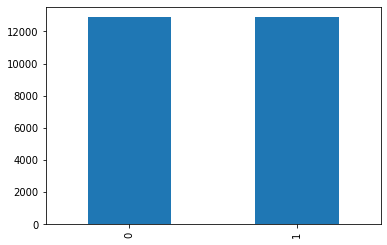

In [15]:
y_train_smote.value_counts().plot(kind ='bar')

# 3. 모델링
- 학습 데이터 : X_train_smote, y_train_smote
- 검증 데이터 : X_val_imputed, y_val
- 시험 데이터 : X_test_imputed, y_test

In [90]:
# from sklearn.preprocessing import OneHotEncoder
# y_train_array = np.array(y_train_smote).reshape(-1, 1)
# y_val_array = np.array(y_val).reshape(-1, 1)
# y_test_array = np.array(y_test).reshape(-1, 1)

# encoder = OneHotEncoder(sparse=False, categories='auto')
# y_train_onehot = encoder.fit_transform(y_train_array)
# y_val_onehot = encoder.fit_transform(y_val_array)
# y_test_onehot = encoder.fit_transform(y_test_array)

### 1. DNN

In [81]:
# def label_smooth(y, ep =0.1):
#     num_classes = len(np.unique(y))
#     y_smooth = y * (1 - ep) + ep / 2
#     return y_smooth

In [16]:
model = tf.keras.models.Sequential([
    Dense(512, activation ='relu', input_shape = (84,)),
    Dense(256, activation ='relu'),
    Dense(128, activation ='relu'),
    Dense(64, activation ='relu'),
    Dense(32, activation ='relu'),
    Dense(2, activation ='softmax'),
])

2023-12-04 14:31:36.855699: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-04 14:31:36.856966: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:01.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-04 14:31:36.864347: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-04 14:31:36.865180: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:01.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-04 14:31:36.865992: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not op

In [17]:
model.compile(optimizer = 'adam',
           loss = 'sparse_categorical_crossentropy',
           metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               43520     
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 2)                 66        
                                                                 
Total params: 218,146
Trainable params: 218,146
Non-trai

In [20]:
early_stop = EarlyStopping(monitor='val_loss', mode = 'min',
                          verbose=1, patience=10)

history = model.fit(x=X_train_smote, y = y_train_smote,
              epochs = 30, batch_size = 20,
              validation_data = (X_val_imputed, y_val), verbose = 1,
              callbacks = [early_stop])

Epoch 1/30
1288/1288 [==============================] - 22s 17ms/step - loss: 0.3197 - acc: 0.8618 - val_loss: 0.2832 - val_acc: 0.8792
Epoch 2/30
1288/1288 [==============================] - 22s 17ms/step - loss: 0.2556 - acc: 0.8959 - val_loss: 0.1779 - val_acc: 0.9480
Epoch 3/30
1288/1288 [==============================] - 22s 17ms/step - loss: 0.2196 - acc: 0.9141 - val_loss: 0.5995 - val_acc: 0.7631
Epoch 4/30
1288/1288 [==============================] - 21s 17ms/step - loss: 0.1850 - acc: 0.9307 - val_loss: 0.5090 - val_acc: 0.8012
Epoch 5/30
1288/1288 [==============================] - 21s 16ms/step - loss: 0.1628 - acc: 0.9399 - val_loss: 0.2711 - val_acc: 0.8876
Epoch 6/30
1288/1288 [==============================] - 20s 16ms/step - loss: 0.1401 - acc: 0.9492 - val_loss: 0.3352 - val_acc: 0.8945
Epoch 7/30
1288/1288 [==============================] - 20s 15ms/step - loss: 0.1369 - acc: 0.9514 - val_loss: 0.3338 - val_acc: 0.8767
Epoch 8/30
1288/1288 [==========================

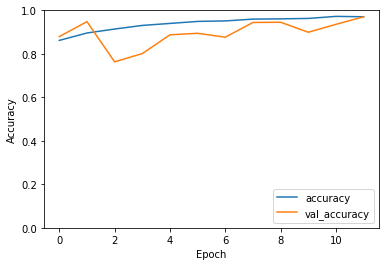

In [23]:
plt.plot(history.history['acc'], label = 'accuracy')
plt.plot(history.history['val_acc'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc = 'lower right')
plt.show()

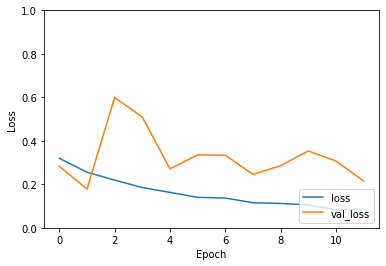

In [24]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc = 'lower right')
plt.show()

In [26]:
y_pred = model.predict(X_test_imputed)

In [27]:
# y_pred_binary = (y_pred > 0.5).astype(int)
y_pred_fin = np.argmax(y_pred, axis=1)
# pd.Series(y_pred_fin).value_counts()

0    4246
1      85
dtype: int64

In [30]:
print("classification Report (Binary):")
print(classification_report(y_test, y_pred_fin))

classification Report (Binary):
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4292
           1       0.02      0.05      0.03        39

    accuracy                           0.97      4331
   macro avg       0.51      0.52      0.51      4331
weighted avg       0.98      0.97      0.98      4331



In [32]:
conf_matrix = confusion_matrix(y_test, y_pred_fin)
conf_matrix

array([[4209,   83],
       [  37,    2]])

In [34]:
from sklearn.metrics import roc_auc_score

In [35]:
roc_auc = roc_auc_score(y_test, y_pred_fin)
print("ROC-AUC Score:", roc_auc)

ROC-AUC Score: 0.5159718737304945


In [36]:
fpr, tpr, th = roc_curve(y_test, y_pred_fin)

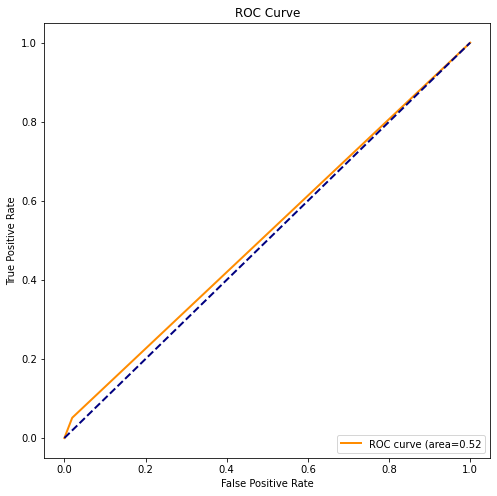

In [38]:
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, color = 'darkorange', lw=2, label=f'ROC curve (area={roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [67]:
y_pred_high_risk = (y_pred[:, 1]>= 0.6).astype(int)

pd.Series(y_pred_high_risk).value_counts()
print("고위험군 수:", sum(y_pred_high_risk == 1)) # 재발 75 명 (60% 이상)
print("저위험군 수:", sum(y_pred_high_risk == 0)) # 

고위험군 수: 75
저위험군 수: 4256


In [71]:
exp = shap.Explainer(model)

In [72]:
shap_values = explainer.shap_values(X_train_smote)

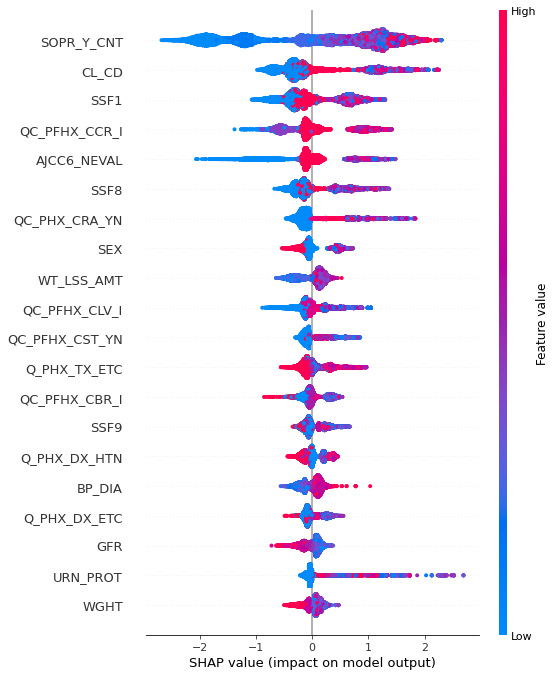

In [73]:
shap.summary_plot(shap_values, X_train_smote)

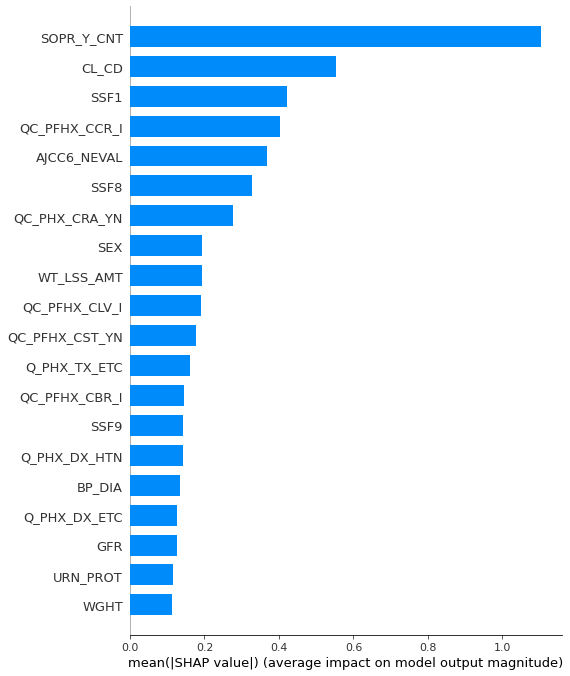

In [74]:
shap.summary_plot(shap_values, X_train_smote, plot_type = 'bar')

In [114]:
# pd.DataFrame(X_test_id, y_te
case_rst =  pd.Series(y_pred_high_risk) # 예측
y_test # 정답
X_test_id #

result = pd.concat([X_test_id, y_test], axis = 1)
result = result.reset_index()


In [115]:
result['case_rst'] = case_rst
result

,index,SN_KEY,LABEL,case_rst
0,14087,SN00040274,0,0
1,9978,SN00028254,0,0
2,10817,SN00030507,0,0
3,5827,SN00016251,0,0
4,15945,SN00045761,0,0
...,...,...,...,...
4326,8230,SN00023199,0,0
4327,14790,SN00042346,0,0
4328,9977,SN00028250,0,0
4329,3848,SN00010621,0,0


In [119]:
case_total = result[result['LABEL'] != result['case_rst']]

In [120]:
case_total

,index,SN_KEY,LABEL,case_rst
11,11216,SN00031687,0,1
100,17502,SN00050440,0,1
224,18095,SN00052090,0,1
234,17,SN00006801,1,0
308,189,SN00060794,1,0
...,...,...,...,...
4149,8765,SN00024701,0,1
4193,5407,SN00015004,0,1
4229,12492,SN00035525,0,1
4247,160,SN00051275,1,0


In [122]:
case_total_nrec = case_total[case_total['LABEL'] == 0]
case_total_nrec

,index,SN_KEY,LABEL,case_rst
11,11216,SN00031687,0,1
100,17502,SN00050440,0,1
224,18095,SN00052090,0,1
442,2126,SN00005662,0,1
484,7166,SN00020175,0,1
...,...,...,...,...
4124,10898,SN00030758,0,1
4126,3357,SN00009203,0,1
4149,8765,SN00024701,0,1
4193,5407,SN00015004,0,1


In [123]:
cust_id = list(case_total_nrec['SN_KEY'])
cust_id

['SN00031687',
 'SN00050440',
 'SN00052090',
 'SN00005662',
 'SN00020175',
 'SN00038799',
 'SN00058767',
 'SN00019631',
 'SN00010707',
 'SN00051835',
 'SN00046234',
 'SN00053546',
 'SN00046758',
 'SN00034894',
 'SN00011162',
 'SN00045541',
 'SN00047257',
 'SN00039433',
 'SN00058724',
 'SN00020174',
 'SN00037207',
 'SN00062103',
 'SN00039911',
 'SN00004523',
 'SN00001152',
 'SN00033897',
 'SN00052783',
 'SN00028592',
 'SN00043549',
 'SN00036783',
 'SN00044591',
 'SN00006006',
 'SN00038095',
 'SN00056345',
 'SN00025805',
 'SN00041889',
 'SN00053149',
 'SN00043333',
 'SN00054386',
 'SN00025323',
 'SN00000549',
 'SN00018182',
 'SN00044646',
 'SN00046757',
 'SN00062285',
 'SN00032085',
 'SN00057756',
 'SN00017675',
 'SN00023927',
 'SN00046585',
 'SN00003374',
 'SN00045291',
 'SN00018272',
 'SN00049766',
 'SN00022905',
 'SN00004781',
 'SN00010737',
 'SN00021971',
 'SN00057736',
 'SN00009832',
 'SN00047815',
 'SN00000182',
 'SN00015191',
 'SN00053882',
 'SN00012740',
 'SN00047624',
 'SN000403

In [128]:
## 재발이 아닌 피험자 불러오기 ###
result_nec_false = df[df['SN_KEY'].isin(cust_id)]
result_nec_false

,SN_KEY,LABEL,SEX,AGE,CL_CD,SOPR_Y_CNT,HGHT,WGHT,BMI,WSTC,BP_SYS,BP_DIA,URN_PROT,HGB,FBS,SGOT,SGPT,GGT,TG,HDL,LDL,TOT_CHOL,CRTN,GFR,TCODE,MCODE_GRP,GRADE,T_SIZE,EXT,LNPOS,METS,SSF1,SSF8,SSF9,AJCC6_T,AJCC6_TEVAL,AJCC6_N,AJCC6_NEVAL,AJCC6_M,AJCC6_MEVAL,AJCC6_STAGE,SS2000,WT_LSS,Q_SMK_YN,Q_DAILY_DRK,Q_DRK_RISK,Q_PA_WGT_AVG,Q_FHX_ETC,Q_PHX_YN,Q_PHX_DX_STK,Q_PHX_DX_HTDZ,Q_PHX_DX_HTN,Q_PHX_DX_DM,Q_PHX_DX_PTB,Q_PHX_DX_DLD,Q_PHX_DX_ETC,Q_PHX_TX_STK,Q_PHX_TX_HTDZ,Q_PHX_TX_HTN,Q_PHX_TX_DM,Q_PHX_TX_DLD,Q_PHX_TX_ETC,WT_LSS_AMT,QC_PFHX_CST_YN,QC_PFHX_CST_I,QC_PFHX_CBR_YN,QC_PFHX_CBR_I,QC_PFHX_CCR_YN,QC_PFHX_CCR_I,QC_PFHX_CLV_YN,QC_PFHX_CLV_I,QC_PFHX_CCX_YN,QC_PFHX_CCX_I,QC_PFHX_ETC_YN,QC_PFHX_ETC_I,QC_PHX_PU_YN,QC_PHX_ATGS_YN,QC_PHX_INMT_YN,QC_PHX_GPO_YN,QC_PHX_ST_ETC,QC_PHX_CRA_YN,QC_PHX_CD_YN,QC_PHX_HMR_YN,QC_PHX_LV_YN,QC_PHX_CHB_YN,QC_PHX_CHC_YN
254,SN00000182,0,1,73,1,10,170.0,70.0,26.0,80.0,150.0,83.0,1.0,15.8,101.0,42.0,32.0,67.0,108.0,50.0,139.0,211.0,1.4,53.0,7,1,0,15.0,450.0,1.0,0.0,0.0,1.0,0.0,2.0,1,2.0,1,0.0,0,5,3.0,1.0,2.0,0.0,0.0,19.0,NaN,2.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
385,SN00000549,0,1,65,0,8,150.0,50.0,20.0,80.0,128.0,84.0,1.0,15.9,102.0,18.0,13.0,45.0,81.0,91.0,107.0,215.0,1.1,71.0,10,1,1,60.0,400.0,0.0,0.0,NaN,0.0,NaN,2.0,1,0.0,1,0.0,0,1,1.0,NaN,1.0,3.4,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
586,SN00001152,0,2,75,1,4,150.0,60.0,30.0,90.0,140.0,80.0,1.0,14.1,109.0,20.0,12.0,20.0,NaN,NaN,NaN,NaN,0.8,73.0,10,1,1,45.0,455.0,0.0,0.0,1.0,0.0,0.0,2.0,1,0.0,1,0.0,0,1,2.0,1.0,1.0,0.0,0.0,12.0,NaN,2.0,NaN,NaN,1.0,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,1.0,1.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,2.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0
1365,SN00003374,0,1,72,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,1,2,70.0,455.0,1.0,1.0,1.0,1.0,NaN,2.0,1,2.0,1,1.0,0,7,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1736,SN00004523,0,2,47,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,1,1,NaN,455.0,NaN,1.0,1.0,NaN,NaN,2.0,0,1.0,0,1.0,0,7,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20057,SN00057756,0,1,46,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,2,70.0,600.0,0.0,0.0,0.0,1.0,NaN,3.0,1,0.0,1,0.0,0,2,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20410,SN00058724,0,1,54,0,1,160.0,60.0,22.0,80.0,124.0,77.0,1.0,14.1,110.0,26.0,12.0,65.0,189.0,52.0,68.0,158.0,1.1,74.0,10,1,0,95.0,500.0,1.0,0.0,1.0,1.0,0.0,3.0,1,2.0,1,0.0,0,5,3.0,1.0,2.0,2.7,0.0,8.3,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
20423,SN00058767,0,1,59,0,3,160.0,50.0,20.0,80.0,140.0,105.0,1.0,15.3,98.0,39.0,33.0,162.0,235.0,66.0,63.0,176.0,1.1,72.0,9,1,1,15.0,455.0,0.0,0.0,1.0,1.0,0.0,2.0,1,0.0,1,0.0,0,1,2.0,1.0,3.0,5.7,0.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
21592,SN

In [127]:
## 재발이 아닌 피험자 불러오기 ###
result_nec_true = df[~df['SN_KEY'].isin(cust_id)]
result_nec_true

,SN_KEY,LABEL,SEX,AGE,CL_CD,SOPR_Y_CNT,HGHT,WGHT,BMI,WSTC,BP_SYS,BP_DIA,URN_PROT,HGB,FBS,SGOT,SGPT,GGT,TG,HDL,LDL,TOT_CHOL,CRTN,GFR,TCODE,MCODE_GRP,GRADE,T_SIZE,EXT,LNPOS,METS,SSF1,SSF8,SSF9,AJCC6_T,AJCC6_TEVAL,AJCC6_N,AJCC6_NEVAL,AJCC6_M,AJCC6_MEVAL,AJCC6_STAGE,SS2000,WT_LSS,Q_SMK_YN,Q_DAILY_DRK,Q_DRK_RISK,Q_PA_WGT_AVG,Q_FHX_ETC,Q_PHX_YN,Q_PHX_DX_STK,Q_PHX_DX_HTDZ,Q_PHX_DX_HTN,Q_PHX_DX_DM,Q_PHX_DX_PTB,Q_PHX_DX_DLD,Q_PHX_DX_ETC,Q_PHX_TX_STK,Q_PHX_TX_HTDZ,Q_PHX_TX_HTN,Q_PHX_TX_DM,Q_PHX_TX_DLD,Q_PHX_TX_ETC,WT_LSS_AMT,QC_PFHX_CST_YN,QC_PFHX_CST_I,QC_PFHX_CBR_YN,QC_PFHX_CBR_I,QC_PFHX_CCR_YN,QC_PFHX_CCR_I,QC_PFHX_CLV_YN,QC_PFHX_CLV_I,QC_PFHX_CCX_YN,QC_PFHX_CCX_I,QC_PFHX_ETC_YN,QC_PFHX_ETC_I,QC_PHX_PU_YN,QC_PHX_ATGS_YN,QC_PHX_INMT_YN,QC_PHX_GPO_YN,QC_PHX_ST_ETC,QC_PHX_CRA_YN,QC_PHX_CD_YN,QC_PHX_HMR_YN,QC_PHX_LV_YN,QC_PHX_CHB_YN,QC_PHX_CHC_YN
0,SN00001062,1,1,68,0,4,170.0,50.0,20.0,70.0,117.0,65.0,1.0,13.7,103.0,27.0,18.0,16.0,72.0,44.0,71.0,129.0,0.9,88.0,10,1,1,NaN,455.0,0.0,0.0,0.0,0.0,NaN,2.0,1,0.0,1,0.0,0,1,2.0,NaN,2.0,0.0,0.0,1.2,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SN00001075,1,1,80,0,2,160.0,50.0,20.0,70.0,116.0,65.0,1.0,13.9,97.0,22.0,15.0,12.0,113.0,52.0,112.0,187.0,1.0,76.0,6,1,1,65.0,160.0,0.0,0.0,NaN,NaN,1.0,0.0,1,0.0,1,0.0,0,0,1.0,1.0,1.0,0.0,0.0,15.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,SN00001282,1,1,66,1,4,150.0,50.0,21.0,70.0,130.0,70.0,1.0,15.0,97.0,24.0,14.0,21.0,57.0,51.0,77.0,139.0,0.9,90.0,0,1,1,50.0,750.0,1.0,1.0,NaN,0.0,NaN,3.0,1,2.0,1,1.0,0,7,0.0,NaN,1.0,24.0,0.0,0.2,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SN00001450,1,2,80,0,4,150.0,40.0,20.0,80.0,160.0,100.0,1.0,11.4,115.0,19.0,12.0,13.0,167.0,36.0,140.0,209.0,0.9,63.0,6,1,1,85.0,450.0,0.0,0.0,0.0,0.0,1.0,2.0,1,0.0,1,0.0,0,1,2.0,NaN,1.0,0.0,0.0,0.0,NaN,2.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SN00002257,1,1,63,0,6,160.0,60.0,22.0,70.0,100.0,60.0,1.0,14.7,107.0,43.0,54.0,342.0,NaN,NaN,NaN,NaN,1.1,71.0,10,1,1,53.0,455.0,1.0,0.0,1.0,1.0,0.0,2.0,1,2.0,1,0.0,0,5,3.0,NaN,1.0,0.0,0.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21648,SN00062267,0,1,62,0,4,160.0,80.0,30.0,90.0,100.0,57.0,1.0,14.4,88.0,18.0,28.0,31.0,67.0,56.0,102.0,171.0,0.6,90.0,6,1,1,50.0,450.0,0.0,0.0,1.0,1.0,NaN,2.0,1,1.0,1,0.0,0,4,3.0,1.0,2.0,16.0,0.0,25.8,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,1.0,2.0,0.0,NaN,0.0,NaN,0.0,NaN,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0
21649,SN00062268,0,1,72,0,5,160.0,50.0,21.0,80.0,127.0,65.0,1.0,13.7,119.0,32.0,32.0,84.0,162.0,77.0,157.0,267.0,1.0,73.0,10,1,1,12.0,455.0,1.0,0.0,0.0,0.0,NaN,2.0,1,1.0,1,0.0,0,4,3.0,1.0,2.0,11.4,0.0,20.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,1.0,1.0,0.0,NaN,0.0,NaN,1.0,1.0,1.0,1.0,1.0,NaN,NaN,2.0,1.0,1.0,1.0
21650,SN00062279,0,1,44,1,1,170.0,60.0,23.0,70.0,108.0,68.0,1.0,13.1,86.0,20.0,19.0,36.0,730.0,67.0,89.0,171.0,1.1,78.0,10,1,1,NaN,455.0,NaN,0.0,NaN,NaN,NaN,2.0,0,1.0,0,0.0,0,4,3.0,NaN,2.0,8.0,0.0,15.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [125]:
result_nec.describe()

,LABEL,SEX,AGE,CL_CD,SOPR_Y_CNT,HGHT,WGHT,BMI,WSTC,BP_SYS,BP_DIA,URN_PROT,HGB,FBS,SGOT,SGPT,GGT,TG,HDL,LDL,TOT_CHOL,CRTN,GFR,TCODE,MCODE_GRP,GRADE,T_SIZE,EXT,LNPOS,METS,SSF1,SSF8,SSF9,AJCC6_T,AJCC6_TEVAL,AJCC6_N,AJCC6_NEVAL,AJCC6_M,AJCC6_MEVAL,AJCC6_STAGE,SS2000,WT_LSS,Q_SMK_YN,Q_DAILY_DRK,Q_DRK_RISK,Q_PA_WGT_AVG,Q_FHX_ETC,Q_PHX_YN,Q_PHX_DX_STK,Q_PHX_DX_HTDZ,Q_PHX_DX_HTN,Q_PHX_DX_DM,Q_PHX_DX_PTB,Q_PHX_DX_DLD,Q_PHX_DX_ETC,Q_PHX_TX_STK,Q_PHX_TX_HTDZ,Q_PHX_TX_HTN,Q_PHX_TX_DM,Q_PHX_TX_DLD,Q_PHX_TX_ETC,WT_LSS_AMT,QC_PFHX_CST_YN,QC_PFHX_CST_I,QC_PFHX_CBR_YN,QC_PFHX_CBR_I,QC_PFHX_CCR_YN,QC_PFHX_CCR_I,QC_PFHX_CLV_YN,QC_PFHX_CLV_I,QC_PFHX_CCX_YN,QC_PFHX_CCX_I,QC_PFHX_ETC_YN,QC_PFHX_ETC_I,QC_PHX_PU_YN,QC_PHX_ATGS_YN,QC_PHX_INMT_YN,QC_PHX_GPO_YN,QC_PHX_ST_ETC,QC_PHX_CRA_YN,QC_PHX_CD_YN,QC_PHX_HMR_YN,QC_PHX_LV_YN,QC_PHX_CHB_YN,QC_PHX_CHC_YN
count,73.0,73.000000,73.000000,73.000000,73.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,44.000000,44.000000,44.000000,44.000000,46.000000,45.000000,73.000000,73.000000,73.000000,59.000000,69.000000,61.000000,71.000000,63.000000,60.000000,36.000000,69.000000,73.000000,70.000000,73.000000,71.000000,73.000000,73.000000,71.000000,36.0,46.000000,43.000000,46.000000,46.000000,26.000000,46.000000,26.000000,25.00,33.000000,28.000000,25.00,29.000000,29.000000,1.0,0.0,16.000000,6.0,7.0,8.000000,0.0,36.000000,2.0,36.0,0.0,36.000000,0.0,36.000000,1.0,36.000000,0.0,35.000000,1.0,34.000000,35.000000,33.000000,34.000000,34.0,36.000000,35.0,35.000000,36.000000,34.0,34.0
mean,0.0,1.232877,65.712329,0.383562,4.287671,160.217391,57.826087,23.130435,78.695652,129.043478,78.673913,1.086957,13.630435,105.521739,31.717391,27.108696,85.282609,122.272727,56.113636,97.068182,177.090909,0.986957,79.133333,6.424658,1.123288,1.410959,54.186441,480.289855,0.540984,0.253521,0.460317,0.416667,0.416667,2.289855,0.767123,0.928571,0.794521,0.253521,0.041096,4.082192,1.901408,1.0,1.913043,10.625581,0.195652,5.132609,0.192308,1.500000,0.076923,0.04,0.515152,0.250000,0.04,0.275862,0.275862,1.0,NaN,0.875000,1.0,1.0,0.875000,NaN,0.111111,1.0,0.0,NaN,0.055556,NaN,0.083333,1.0,0.055556,NaN,0.085714,1.0,1.029412,1.057143,1.030303,1.029412,1.0,1.027778,1.0,1.057143,1.055556,1.0,1.0
std,0.0,0.425589,9.768827,0.489618,3.683595,7.742848,9.407572,2.680039,8.057762,15.967963,11.475683,0.354406,2.706196,23.186911,14.741722,15.626513,108.645328,71.363910,17.597854,32.818314,38.916021,0.166812,12.728993,3.427494,0.599657,1.331620,21.935230,100.318918,0.502453,0.438123,0.502426,0.497167,0.500000,0.571413,0.457060,0.804362,0.470192,0.438123,0.199886,2.301892,1.353883,0.0,0.864769,10.421020,0.748912,7.024720,0.401918,0.505525,0.271746,0.20,0.507519,0.440959,0.20,0.454859,0.454859,NaN,NaN,0.341565,0.0,0.0,0.353553,NaN,0.398410,0.0,0.0,NaN,0.333333,NaN,0.368394,NaN,0.333333,NaN,0.373491,NaN,0.171499,0.235504,0.174078,0.171499,0.0,0.166667,0.0,0.235504,0.232311,0.0,0.0
min,0.0,1.000000,42.000000,0.000000,0.000000,150.000000,40.000000,20.000000,60.000000,91.000000,51.000000,1.000000,4.000000,72.000000,12.000000,8.000000,13.000000,50.000000,33.000000,31.000000,118.000000,0.800000,48.000000,0.000000,1.000000,0.000000,15.000000,160.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,1.0,NaN,0.000000,1.0,1.0,0.000000,NaN,0.000000,1.0,0.0,NaN,0.000000,NaN,0.000000,1.0,0.000000,NaN,0.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.0,1.0
25%,0.0,1.000000,59.000000,0.000000,2.000000,150.000000,50.000000,21.000000,70.000000,120.000000,70.000000,1.000000,13.050000,94.000000,22.000000,16.000000,26.250000,77.750000,44.750000,70.250000,144.250000,0.900000,72.000000,3.000000,1.000000,1.000000,45.000000,450.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,

In [145]:
result_nec_false[['AJCC6_NEVAL']].value_counts()

AJCC6_NEVAL
1              54
0              17
2               2
dtype: int64

In [146]:
result_nec_true[['AJCC6_NEVAL']].value_counts()

AJCC6_NEVAL
1              14429
0               6909
2                243
dtype: int64

In [129]:
result_nec_true.describe()

,LABEL,SEX,AGE,CL_CD,SOPR_Y_CNT,HGHT,WGHT,BMI,WSTC,BP_SYS,BP_DIA,URN_PROT,HGB,FBS,SGOT,SGPT,GGT,TG,HDL,LDL,TOT_CHOL,CRTN,GFR,TCODE,MCODE_GRP,GRADE,T_SIZE,EXT,LNPOS,METS,SSF1,SSF8,SSF9,AJCC6_T,AJCC6_TEVAL,AJCC6_N,AJCC6_NEVAL,AJCC6_M,AJCC6_MEVAL,AJCC6_STAGE,SS2000,WT_LSS,Q_SMK_YN,Q_DAILY_DRK,Q_DRK_RISK,Q_PA_WGT_AVG,Q_FHX_ETC,Q_PHX_YN,Q_PHX_DX_STK,Q_PHX_DX_HTDZ,Q_PHX_DX_HTN,Q_PHX_DX_DM,Q_PHX_DX_PTB,Q_PHX_DX_DLD,Q_PHX_DX_ETC,Q_PHX_TX_STK,Q_PHX_TX_HTDZ,Q_PHX_TX_HTN,Q_PHX_TX_DM,Q_PHX_TX_DLD,Q_PHX_TX_ETC,WT_LSS_AMT,QC_PFHX_CST_YN,QC_PFHX_CST_I,QC_PFHX_CBR_YN,QC_PFHX_CBR_I,QC_PFHX_CCR_YN,QC_PFHX_CCR_I,QC_PFHX_CLV_YN,QC_PFHX_CLV_I,QC_PFHX_CCX_YN,QC_PFHX_CCX_I,QC_PFHX_ETC_YN,QC_PFHX_ETC_I,QC_PHX_PU_YN,QC_PHX_ATGS_YN,QC_PHX_INMT_YN,QC_PHX_GPO_YN,QC_PHX_ST_ETC,QC_PHX_CRA_YN,QC_PHX_CD_YN,QC_PHX_HMR_YN,QC_PHX_LV_YN,QC_PHX_CHB_YN,QC_PHX_CHC_YN
count,21581.000000,21581.000000,21581.000000,21581.000000,21581.000000,16418.000000,16418.000000,16418.000000,16419.000000,16378.000000,16378.000000,16217.000000,16376.000000,16378.000000,16378.000000,16377.000000,16378.000000,15753.000000,15753.000000,15667.000000,15753.000000,16378.000000,16229.000000,21581.000000,21581.000000,21581.000000,18274.000000,20344.000000,16045.000000,21143.000000,18590.000000,17583.000000,9552.000000,20344.000000,21581.000000,20648.000000,21581.000000,21143.000000,21581.000000,21581.000000,21055.000000,12649.000000,16418.000000,15977.000000,16415.000000,16409.000000,10248.000000,16424.000000,9590.000000,9741.000000,12235.000000,10615.000000,9528.000000,9830.000000,10354.000000,324.000000,731.000000,5902.000000,2455.000000,840.000000,2429.000000,341.000000,12592.000000,814.000000,12545.000000,179.000000,12595.000000,1270.000000,12568.000000,317.000000,12547.000000,175.000000,12201.000000,835.000000,11785.000000,11871.000000,11482.000000,11533.000000,11841.000000,11938.000000,11707.000000,12152.000000,12452.000000,12378.000000,12374.000000
mean,0.008989,1.399564,65.252722,0.249664,2.578194,158.424900,58.862833,23.766476,78.664352,127.589083,77.755648,1.139113,13.673321,107.299487,26.737819,24.009770,43.357553,142.158065,52.540405,114.788792,194.697264,0.942606,84.704602,6.358788,1.071174,1.166860,44.071085,385.872641,0.419196,0.184033,0.399354,0.243246,0.389238,1.675629,0.775914,0.634444,0.691117,0.184033,0.042120,3.091794,1.706388,1.027907,1.660434,8.922564,0.162473,5.934969,0.212041,1.542560,0.036184,0.076891,0.490805,0.236269,0.028128,0.089013,0.253332,0.910494,0.956224,0.977974,0.968228,0.933333,0.779745,5.917889,0.122538,1.186732,0.048545,1.324022,0.140611,1.762992,0.065643,1.160883,0.048059,1.285714,0.117285,1.341317,1.062367,1.077079,1.003135,1.013787,1.068406,1.050762,1.000085,1.082702,1.019515,1.005090,1.003394
std,0.094387,0.489820,11.462692,0.432829,2.181726,7.825952,10.991170,2.797926,8.395486,15.780313,10.219291,0.566831,1.868004,33.331724,19.547545,21.675535,65.405477,97.548787,16.610918,44.925781,43.222551,1.145273,27.617410,3.390802,0.453218,1.133125,31.182763,146.160350,0.493443,0.387520,0.489779,0.429055,0.487603,0.965931,0.454323,0.760608,0.485803,0.387520,0.215127,2.696728,1.242416,0.164714,0.806561,17.285715,0.594832,8.499197,0.408774,0.498201,0.186756,0.266433,0.499936,0.424810,0.165346,0.284777,0.434940,0.285915,0.204736,0.146782,0.175428,0.249592,0.414504,2.512147,0.375985,0.389936,0.276560,0.469321,0.388412,0.425415,0.304974,0.368004,0.277198,0.453050,0.368110,0.474436,0.241832,0.266727,0.055909,0.116609,0.252453,0.219521,0.009242,0.275443,0.138332,0.071163,0.058163
min,0.000000,1.000000,29.000000,0.000000,0.000000,150.000000,40.000000,20.000000,60.000000,70.000000,40.000000,1.000000,1.800000,45.000000,4.000000,3.000000,1.000000,18.000000,6.000000,1.000000,69.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,130.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000

----

### 2. XGBoost

In [30]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform
from sklearn.metrics import classification_report, confusion_matrix

param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth' : [None, 10, 20, 30, 40, 50],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11),
    'criterion' : ['gini', 'entropy']
}

model_rf = RandomForestClassifier()
random_search_rf = RandomizedSearchCV(model_rf, param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search_rf.fit(X_train_smote, y_train_smote)


print("최적 하이퍼파라미터:", random_search_rf.best_params_)

y_pred = random_search_rf.predict(X_test_imputed)

acc = accuracy_score(y_test, y_pred)
print(f'정확도: {acc}')

y_pred_probs = random_search_rf.predict_proba(X_test_imputed)
y_pred = random_search_rf.predict(X_test_imputed)

thd = 0.6 # 예측 확률이 0.6 이상이면 고위험군으로 분류

y_pred_high_risk = (y_pred_probs[:, 1] >= thd).astype(int)

print("confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("고위험군 수:", sum(y_pred_high_risk == 1))
print("중위험군 수:", sum((y_pred_high_risk == 0) & (y_pred == 1)))
print("저위험군 수:", sum((y_pred_high_risk == 0) & (y_pred == 0)))

최적 하이퍼파라미터: {'criterion': 'gini', 'max_depth': 40, 'min_samples_leaf': 9, 'min_samples_split': 8, 'n_estimators': 100}
정확도: 0.9909951512352805
confusion Matrix:
[[4292    0]
 [  39    0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4292
           1       0.00      0.00      0.00        39

    accuracy                           0.99      4331
   macro avg       0.50      0.50      0.50      4331
weighted avg       0.98      0.99      0.99      4331

고위험군 수: 0
중위험군 수: 0
저위험군 수: 4331


In [68]:
model_xgb = xgb.XGBClassifier(learning_rate=0.1,
                             n_jobs = -1,
                             n_estimators = 500,
                             random_state = 21)

In [69]:
eval_set = [(X_val_imputed, y_val)]

model_xgb.fit(X_train_smote, y_train_smote, early_stopping_rounds=10,
             eval_metric = "logloss", eval_set=eval_set, verbose=True)

[0]	validation_0-logloss:0.61951
[1]	validation_0-logloss:0.55859
[2]	validation_0-logloss:0.50645
[3]	validation_0-logloss:0.46191
[4]	validation_0-logloss:0.42367
[5]	validation_0-logloss:0.38759
[6]	validation_0-logloss:0.35452
[7]	validation_0-logloss:0.32791
[8]	validation_0-logloss:0.30281
[9]	validation_0-logloss:0.28054
[10]	validation_0-logloss:0.25978
[11]	validation_0-logloss:0.24291
[12]	validation_0-logloss:0.22440
[13]	validation_0-logloss:0.20909
[14]	validation_0-logloss:0.19650
[15]	validation_0-logloss:0.18502
[16]	validation_0-logloss:0.17344
[17]	validation_0-logloss:0.16308
[18]	validation_0-logloss:0.15427
[19]	validation_0-logloss:0.14553
[20]	validation_0-logloss:0.13691
[21]	validation_0-logloss:0.12890
[22]	validation_0-logloss:0.12196
[23]	validation_0-logloss:0.11556
[24]	validation_0-logloss:0.10983
[25]	validation_0-logloss:0.10436
[26]	validation_0-logloss:0.09925
[27]	validation_0-logloss:0.09518
[28]	validation_0-logloss:0.09074
[29]	validation_0-loglos

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=21,
              reg_alpha=0, reg_lambda=1, ...)

In [79]:
y_pred_xgb = model_xgb.predict(X_test_imputed)

array([0, 0, 0, ..., 0, 0, 0])

In [76]:
acc = accuracy_score(y_test, y_pred_xgb)
print(f'정확도: {acc}')

정확도: 0.9905333641191411


In [80]:
y_pred_probs_xgb = model_xgb.predict_proba(X_test_imputed)
y_pred_probs_xgb

array([[9.9705786e-01, 2.9421705e-03],
       [9.9912864e-01, 8.7133574e-04],
       [9.8353332e-01, 1.6466692e-02],
       ...,
       [9.9860609e-01, 1.3938991e-03],
       [9.9937689e-01, 6.2313379e-04],
       [9.9656665e-01, 3.4333691e-03]], dtype=float32)

In [81]:
print("confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

confusion Matrix:
[[4290    2]
 [  39    0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4292
           1       0.00      0.00      0.00        39

    accuracy                           0.99      4331
   macro avg       0.50      0.50      0.50      4331
weighted avg       0.98      0.99      0.99      4331



In [70]:
explainer = shap.TreeExplainer(model_xgb)

In [82]:
shap_values = explainer.shap_values(X_train_smote)

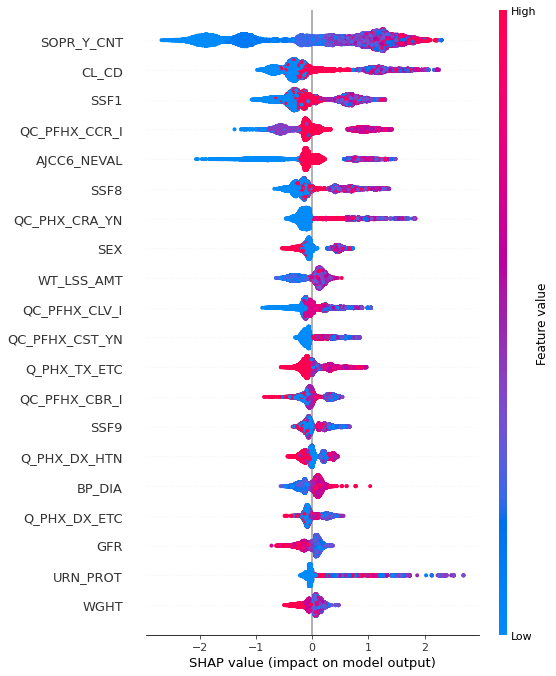

In [85]:
shap.summary_plot(shap_values, X_train_smote)